In [1]:
import torch 
from torch import Tensor 
import numpy as np
import math
import matplotlib.pyplot as plt
import math

In [2]:
class Relu:
    def forward(self, x):   
        self.x = x.clone()
        return x.clamp(min=0)
    
    def backward(self, dz):
        output = self.x.clone()
        output[output > 0] = 1
        output[output < 0] = 0
#         print("forwarded x")
#         print(self.x[:5])
#         print("output")
#         print(output[:5])
#         print("dz come")
#         print(dz[:5])
#         print("backwarded update")
#         print(dz.mul(output).shape)
        return dz.mul(output)

In [3]:
class Tanh:
    
    def forward(self, x):
        self.x = x.clone()
        self.output = Tensor.tanh(x)
        return self.output;

    def backward(self, dz):
#         print("forwarded x")
#         print(self.x[:5])
#         print("output")
#         print(self.output[:5])
#         print("dz come")
#         print(dz[:5])
#         print("backwarded update")
#         print(dz.mul(1.0 - Tensor.tanh(self.x).pow(2))[:5])
        return dz.mul(1.0 - Tensor.tanh(self.x).pow(2))
        

In [24]:
class Linear:
    
    def __init__(self, input_size ,hidden_nodes):    
        
        # Initialize weight, bias xavie initializer
        stdv = 1. / math.sqrt(input_size)
        self.w = Tensor(hidden_nodes, input_size).uniform_(-stdv, stdv)
        self.b = Tensor(hidden_nodes).uniform_(-stdv, stdv) 
#         self.w = Tensor(hidden_nodes, input_size).uniform_(-2*stdv, stdv)
#         self.b = Tensor(hidden_nodes).uniform_(-2*stdv, stdv) 

        self.dw = Tensor(self.w.size()).zero_()
        self.db = Tensor(self.b.size()).zero_()
        
    def forward(self, x):
        self.x = x.clone()
        s = x.matmul(self.w.t()) + self.b
        return s
        
    def backward(self, dz):
        
        dx = dz.matmul(self.w)
        dw = self.x.t().matmul(dz)
        db = dz.t().sum(1)
        
        self.dw += dw
        self.db += db
        
        return dx
        
    def params(self):
        return (self.w, self.b, self.dw,self.db)
    
    
    def update_params(self, lambda_):
        self.w -= lambda_ * self.dw
        self.b -= lambda_ * self.db
        
    
    def zero_gradient(self):
        self.dw.zero_()
        self.db.zero_()

In [5]:
class LossMSE: 
        
    def forward(self, t, x):
        self.t = t.clone()
        self.x = x.clone()
        self.output = (self.x - self.t).pow(2).mean()

        return self.output
    
    def backward(self):
#         print("t")
#         print(self.t)
#         print("x")
#         print(self.x)
#         print("error")
#         print(self.output)
        dloss = 2 * (self.t - self.x)/self.x.shape[0]/2
#         print(self.x.shape)
        return dloss

In [6]:
class Sequential:
    
    def __init__(self, layer_modules):
        self.layer_modules = layer_modules

        
    def forward(self, x_input):
        module_input = x_input.clone()
        
        # hidden layer
        for i in range(len(self.layer_modules)): 
            module_output = self.layer_modules[i].forward(module_input)
            module_input = module_output
        return module_output
    
    def backward(self, dz):
        for i in range(len(self.layer_modules) - 1, -1, -1):
            dz = self.layer_modules[i].backward(dz) 
    
    def update_params(self, lambda_):
        for m in self.layer_modules:
            if isinstance(m, Linear): 
                m.update_params(lambda_);

    
    def zero_gradient(self):
        for m in self.layer_modules:
            if isinstance(m, Linear):
                m.zero_gradient()
    
    def get_params(self):
        for m in self.layer_modules:
            print('{},{}'.format(m.params()[0], m.params()[1]))


In [7]:
def train_model(model, train_input, train_target, test_input, test_target, nb_epochs, lr,mini_batch_size ):
    
    criterion = LossMSE()
    
    for m in range(nb_epochs):

        total_loss = 0    
        
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model.forward(train_input.narrow(0, b, mini_batch_size))
#             print(output)
            total_loss  += criterion.forward(output, train_target.narrow(0, b, mini_batch_size))
            model.zero_gradient()
            dloss = criterion.backward()
#             print("dloss")
#             print(dloss[:5])
            model.backward(dloss)
            model.update_params(lr)
        
        train_errors = compute_nb_errors(model, train_input, train_target)
        test_errors = compute_nb_errors(model, test_input, test_target)
        print("================================{}===================================".format(m))
        
        print(  '{}/{}: train_loss: {} train_error {:.02f}% test_error {:.02f}%'.format(m , nb_epochs,total_loss,
                train_errors/ train_input.size(0) * 100,
                test_errors / test_input.size(0) * 100))  

def compute_nb_errors(model, data_input, data_target):

    nb_data_errors = 0

    for b in range(0, data_input.size(0), mini_batch_size):
        output = model.forward(data_input.narrow(0, b, mini_batch_size))
        _, predicted_classes = torch.max(output, 1)
        for k in range(0, mini_batch_size):
            if data_target[b + k][predicted_classes[k]]  < 0:
                nb_data_errors = nb_data_errors + 1

    return nb_data_errors

### Generate data

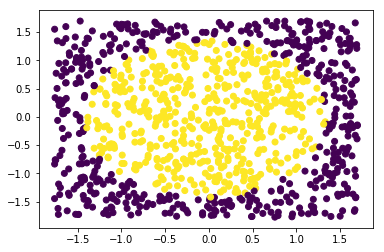

In [8]:
data = torch.FloatTensor(1000,2).uniform_(0, 1) - 0.5
distance = torch.sqrt(torch.pow(data[:, 0], 2) + torch.pow(data[:,1],2)).view(-1,1)
radius = 1 / math.sqrt(2 * math.pi)
inside = distance.clone().apply_(lambda x : 1 if x < radius else  -1)
outside = distance.clone().apply_(lambda x : 1 if x > radius else  -1)

target = torch.cat((inside, outside),1)


data = (data - data.mean())/ data.std()
# plt.scatter(data[:,0], data[:,1], c=inside)
# plt.show()
plt.scatter(data[:,0], data[:,1], c=inside.squeeze())
plt.show()

## Train model

In [26]:
lr =  0.1
mini_batch_size = 200
nb_epochs = 100
# modules = [Linear(2, 25), Relu(),Linear(25, 25),Relu(),Linear(25, 25),Relu(),Linear(25, 2), Tanh()]
modules = [Linear(2, 25), Relu(), Linear(25,25), Relu(), Linear(25, 2), Tanh()]
model = Sequential(modules)

train_input, train_target, test_input, test_target = data[0:800,], target[0:800,], data[800:,], target[800:,]

train_model(model, train_input, train_target, test_input, test_target, nb_epochs, lr, mini_batch_size)


/home/cheng-chun-epfl/anaconda3/lib/python3.6/site-packages/torch/tensor.py:309: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)


================================0===================================
0/100: train_loss: 4.23631900973618 train_error 65.88% test_error 67.00%
================================1===================================
1/100: train_loss: 4.160014840364456 train_error 64.50% test_error 68.50%
================================2===================================
2/100: train_loss: 4.129288845211268 train_error 64.50% test_error 68.00%
================================3===================================
3/100: train_loss: 4.109382317215204 train_error 61.50% test_error 65.50%
================================4===================================
4/100: train_loss: 4.0909296140074725 train_error 59.00% test_error 64.00%
================================5===================================
5/100: train_loss: 4.0725584667176005 train_error 57.12% test_error 62.50%
================================6===================================
6/100: train_loss: 4.053183524757624 train_error 55.25% test_error 60.00